In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import norm
import matplotlib.pyplot as plt
from itertools import product


# Kriging / Gaussian-Process regression for IV vs. moneyness (1D)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel as C, Matern, WhiteKernel
)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor


# Black-Scholes Call Option Formula

In [8]:
def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2.) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


# Parameters

In [9]:
r = 0.01                                         # constant risk-free rate

# Train data for price approximation

In [14]:
S = np.linspace(0.001, 300, 25) # stock price
K = np.linspace(0.001, 300, 25) # strike price
T = np.linspace(0.02, 2.0, 20) # time to maturity (in years)
sigma = np.linspace(0.05, 0.6, 10) # volatility

grid = np.array(list(product(S, K, T, sigma)))
df = pd.DataFrame(grid, columns=["S", "K", "T", "sigma"])

V =  bs_call_price(df["S"], df["K"], df["T"], df["sigma"], r) # target variable

df["log(S/K)"] = np.log(df["S"] / df["K"]) 
df["sqrt(T)"]  = np.sqrt(df["T"]) 
df["sigma*sqrt(T)"] = df["sigma"] * np.sqrt(df["T"])

use_engineered = False # so that i can chnge if i want to use engineered features or not
if use_engineered: # engineer features that are already in the formula so that the NN can have an easier timr predicting the true formula
    feature_names = ["S","K","T","sigma","log(S/K)","sqrt(T)","sigma*sqrt(T)"]
else:
    feature_names = ["S","K","T","sigma"]

X_new = df[feature_names]
X_new


,S,K,T,sigma
0,0.001,0.001,0.02,0.050000
1,0.001,0.001,0.02,0.111111
2,0.001,0.001,0.02,0.172222
3,0.001,0.001,0.02,0.233333
4,0.001,0.001,0.02,0.294444
...,...,...,...,...
124995,300.000,300.000,2.00,0.355556
124996,300.000,300.000,2.00,0.416667
124997,300.000,300.000,2.00,0.477778
124998,300.000,300.000,2.00,0.538889


# Forming dataset

In [15]:
rng = np.random.default_rng(10)
# create train, and test sets. 85-15 split
X_train, X_test, y_train, y_test = train_test_split(X_new, V, test_size=0.15, random_state=10)

# Scale inputs for faster convergence
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Neural Net: Option Price Approximation

In [ ]:
# build model
model_price = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_s.shape[1],)),               
    tf.keras.layers.Dense(128, activation=tf.nn.softplus),
    tf.keras.layers.Dense(128, activation=tf.nn.softplus),
    tf.keras.layers.Dense(64, activation=tf.nn.softplus),
    tf.keras.layers.Dense(32, activation=tf.nn.softplus),
    tf.keras.layers.Dense(
        1,
        kernel_constraint=tf.keras.constraints.NonNeg(),   # ensure non-negative output weights
        bias_constraint=tf.keras.constraints.NonNeg()
    )
])

model_price.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
    loss='mse',
    metrics=['mae']
)
 # early stopping to prevent overfitting/ wasting time 
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=1
)

history = model_price.fit(
    X_train_s, y_train,
    validation_split=0.15, # automatically validates with 15% of training data
    epochs=1000,
    batch_size=256,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1119.6904 - mae: 17.3033 - val_loss: 18.2067 - val_mae: 2.6395
Epoch 2/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.0472 - mae: 1.9749 - val_loss: 9.2457 - val_mae: 1.6785
Epoch 3/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1493 - mae: 1.6288 - val_loss: 6.7571 - val_mae: 1.4960
Epoch 4/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7767 - mae: 1.3812 - val_loss: 4.8279 - val_mae: 1.2847
Epoch 5/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0468 - mae: 1.1904 - val_loss: 3.5112 - val_mae: 1.1127
Epoch 6/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7294 - mae: 0.9850 - val_loss: 1.8576 - val_mae: 0.8204
Epoch 7/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8925 - mae: 0.8398 - val_loss: 0.9936 - val_mae: 0.5948
Epoch 8/1000
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4070 - mae: 0.7254 - val_loss: 0.6497 - val_mae: 0.4831
Epoch 9/1000
353/353 ━━━━━━━━━━━━━

In [17]:
y_pred = model_price.predict(X_test_s, verbose=0).ravel() # predict the price
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R^2 : {r2:.6f}")

Test MSE : 0.003040
Test MAE : 0.032239
Test R^2 : 1.000000


Plot the result

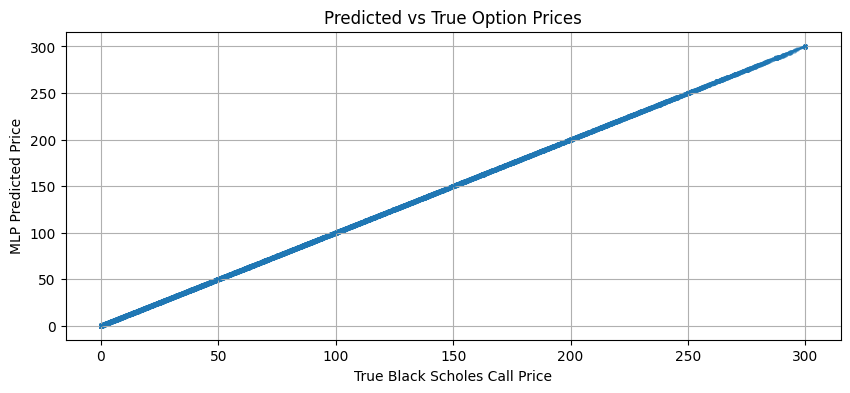

In [ ]:
plt.figure(figsize=(10, 4))

plt.scatter(y_test, y_pred, s=6, alpha=0.4)
mn, mx = np.min(y_test), np.max(y_test)
plt.plot([mn, mx], [mn, mx], linewidth=2)  # 45° parity line
plt.xlabel("True Black Scholes Call Price")
plt.ylabel("MLP Predicted Price")
plt.title("Predicted vs True Option Prices")
plt.grid(True)
plt.show()

# The plot shows that the MLP model is able to predict the Black-Scholes call prices with high accuracy, as the points closely follow the 45-degree parity line.
